```
# 60.19/20
01c932213afb09e5df84b8f061315ccaf01150b4  ../../data/shehui/shehui_phones_loglik.csv
1dc688287a27da6582e17cc3e04ad8fe1a928ce4  ../../data/shehui/shehui_feats.csv
```

In [1]:
phones_df_path = "../../data/shehui/shehui_phones_loglik.csv"
feats_df_path = "../../data/shehui/shehui_feats.csv"
acfeats_path = "../../data/shehui/shehui_acoustics_shift_10ms.csv"  # acoustic features from Praat
annot_path = "../../data/shehui/shehui_judge.csv"  # manual annotation
!sha1sum $phones_df_path $feats_df_path $acfeats_path $annot_path

01c932213afb09e5df84b8f061315ccaf01150b4  ../../data/shehui/shehui_phones_loglik.csv
1dc688287a27da6582e17cc3e04ad8fe1a928ce4  ../../data/shehui/shehui_feats.csv
5c6dbb7aa1b66fd76a56e122720f099f48e75a5a  ../../data/shehui/shehui_acoustics_shift_10ms.csv
7338ee4755f5853be3cd6a3ce7711553485e84fc  ../../data/shehui/shehui_judge.csv


## Load Data

In [2]:
import pandas as pd
WORD = "社會"
phones_df = pd.read_csv(phones_df_path)
fafeats_df = pd.read_csv(feats_df_path)
acfeats_df = pd.read_csv(acfeats_path)
annot_df = pd.read_csv(annot_path, header=None, names=["utt_id", "annot"])
annot_df.annot.fillna("ʂ", inplace=True)
annot_df.annot = annot_df.annot.str.replace("d", "s")

In [3]:
acfeats_df.head()

,file,times,cog,sd,sk,kt
0,ZWH_GY_1203,0,1422.999784,1987.264706,1.356341,1.109356
1,ZWH_GY_1203,1,2361.731875,2372.780208,0.638981,-0.356338
2,ZWH_GY_1203,2,3383.371160,2269.120446,-0.196466,-0.569342
3,ZWH_GY_1203,3,4049.714782,2147.545847,-0.379987,0.403159
4,ZWH_GY_1203,4,4592.580562,1814.476466,-0.880846,2.331999


In [4]:
print(acfeats_df.groupby("file").count().times.head())
print(fafeats_df.groupby("utt_id").count().t.head())

file
CJH_GY_1544    37
CJH_GY_2944    35
CJJ_GY_3607    67
CJJ_GY_3612    34
CJJ_GY_3628    25
Name: times, dtype: int64
utt_id
CJH_GY_1544    35
CJH_GY_2944    30
CJJ_GY_3607    62
CJJ_GY_3612    28
CJJ_GY_3628    19
Name: t, dtype: int64


In [5]:
annot_df.head()

,utt_id,annot
0,CJH_GY_1544,ʂ
1,CJH_GY_2944,ʂ
2,CJJ_GY_3607,ʂ
3,CJJ_GY_3612,ʂ
4,CJJ_GY_3628,ʂ


In [6]:
from tqdm.auto import tqdm
from scipy.interpolate import interp1d

fa_merged = []
for utt_id, utt_df in tqdm(fafeats_df.groupby("utt_id")):
  onset_phone = utt_df.phone.iloc[0]
  ph_utt_df = phones_df.query(f"utt_id=='{utt_id}'")
  ph_utt_df = ph_utt_df.loc[ph_utt_df.phone==onset_phone, :]
  fa_utt_df = utt_df.loc[utt_df.phone==onset_phone, :]
  annot_phone = annot_df.query(f"utt_id=='{utt_id}'").annot.iloc[0]
  assert ph_utt_df.shape[0] == fa_utt_df.shape[0]

  ac_utt_df = acfeats_df.query(f"file=='{utt_id}'")
  fa_utt_df = fa_utt_df.assign(
                cog=ac_utt_df.iloc[:fa_utt_df.shape[0], :].cog.values,
                annot_phone=annot_phone,
                retroLL=ph_utt_df.loc[:,"ʂ"],
                dentalLL=ph_utt_df.loc[:,"s"],
                dentalLLR=ph_utt_df.loc[:,"s"]-ph_utt_df.loc[:,"ʂ"])
  fa_merged.append(fa_utt_df)
fa_merged_df = pd.concat(fa_merged)

  0%|          | 0/101 [00:00<?, ?it/s]

In [7]:
fa_merged_df.shape

(1202, 49)

In [8]:
fa_merged_df.head()

,utt_id,t,phone,ml_phone,0,1,2,3,4,5,...,35,36,37,38,39,cog,annot_phone,retroLL,dentalLL,dentalLLR
2030,CJH_GY_1544,0,s,ej,1.589604,-0.595430,-0.325304,0.677649,-0.534894,0.262331,...,-0.454915,1.241518,-0.505257,-1.974745,1.761001,1523.473758,ʂ,-5.248848,-4.608849,0.639999
2031,CJH_GY_1544,1,s,io,1.841698,-0.618337,-3.467152,0.959866,-0.160864,0.128380,...,-0.894822,1.217367,-0.161628,-1.956079,0.158381,3256.293592,ʂ,-6.753552,-4.515251,2.238300
2032,CJH_GY_1544,2,s,io,2.403394,-0.868217,-1.558381,0.993396,0.293671,0.055854,...,-0.310091,1.791004,1.198298,-1.502081,-0.619665,4032.376099,ʂ,-7.222897,-6.785496,0.437401
2033,CJH_GY_1544,3,s,io,2.639519,-1.088171,-0.038202,1.015769,1.289691,0.038497,...,0.531806,1.594448,-0.219690,-1.383484,-2.136823,4328.858134,ʂ,-6.205521,-5.658013,0.547508
2034,CJH_GY_1544,4,s,f,3.024319,-1.399138,-0.417912,1.078131,-0.305901,0.011729,...,0.384148,-1.091606,-0.479341,-1.044972,-1.552898,4244.724536,ʂ,-6.594359,-5.185797,1.408562


In [9]:
fa_merged_df.columns.get_loc("0")

4

In [17]:
from sklearnex.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


tsne = TSNE()
feat0_idx = fa_merged_df.columns.get_loc("0")
proj_feat = tsne.fit_transform(fa_merged_df.iloc[:, feat0_idx:feat0_idx+40])

/home/seantyh/miniconda3/envs/mfa/lib/python3.11/site-packages/daal4py/sklearn/manifold/_t_sne.py:361: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn("The PCA initialization in TSNE will change to "


In [11]:
fa_merged_df

,utt_id,t,phone,ml_phone,0,1,2,3,4,5,...,35,36,37,38,39,cog,annot_phone,retroLL,dentalLL,dentalLLR
2030,CJH_GY_1544,0,s,ej,1.589604,-0.595430,-0.325304,0.677649,-0.534894,0.262331,...,-0.454915,1.241518,-0.505257,-1.974745,1.761001,1523.473758,ʂ,-5.248848,-4.608849,0.639999
2031,CJH_GY_1544,1,s,io,1.841698,-0.618337,-3.467152,0.959866,-0.160864,0.128380,...,-0.894822,1.217367,-0.161628,-1.956079,0.158381,3256.293592,ʂ,-6.753552,-4.515251,2.238300
2032,CJH_GY_1544,2,s,io,2.403394,-0.868217,-1.558381,0.993396,0.293671,0.055854,...,-0.310091,1.791004,1.198298,-1.502081,-0.619665,4032.376099,ʂ,-7.222897,-6.785496,0.437401
2033,CJH_GY_1544,3,s,io,2.639519,-1.088171,-0.038202,1.015769,1.289691,0.038497,...,0.531806,1.594448,-0.219690,-1.383484,-2.136823,4328.858134,ʂ,-6.205521,-5.658013,0.547508
2034,CJH_GY_1544,4,s,f,3.024319,-1.399138,-0.417912,1.078131,-0.305901,0.011729,...,0.384148,-1.091606,-0.479341,-1.044972,-1.552898,4244.724536,ʂ,-6.594359,-5.185797,1.408562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,ZWH_GY_5146,6,s,sil,4.491157,-0.137228,0.537606,1.528482,0.045808,-1.046817,...,0.286886,0.973590,-0.124207,0.353982,0.294707,6869.196734,ʂ,-6.763131,-3.576562,3.186569
1167,ZWH_GY_5146,7,s,s,3.846450,0.273790,-0.768866,1.147881,-0.527950,-0.860484,...,1.102769,-0.789699,0.422996,0.527090,-0.377933,6384.197005,ʂ,-3.270415,-0.136302,3.134113
1168,ZWH_GY_5146,8,s,s,3.234268,0.614484,-0.087300,1.293192,-0.319316,-0.558049,...,1.927192,-1.246896,1.432941,0.260838,-1.855486,6088.662542,ʂ,-6.546408,-0.216158,6.330250
1169,ZWH_GY_5146,9,s,ɕ,2.308225,0.854694,3.278782,1.355158,0.112047,-0.330340,...,1.586239,-0.659148,-1.556758,-0.138324,-2.298186,5153.520612,ʂ,-5.863108,-1.791113,4.071995


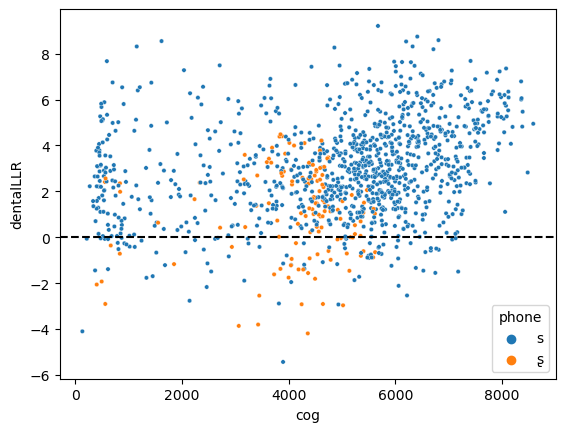

In [18]:
sns.scatterplot(x="cog", y="dentalLLR", 
                hue="phone",
                data=fa_merged_df, s=10)
plt.axhline(0, color="k", linestyle="--")

<Axes: xlabel='cog', ylabel='dentalLLR'>

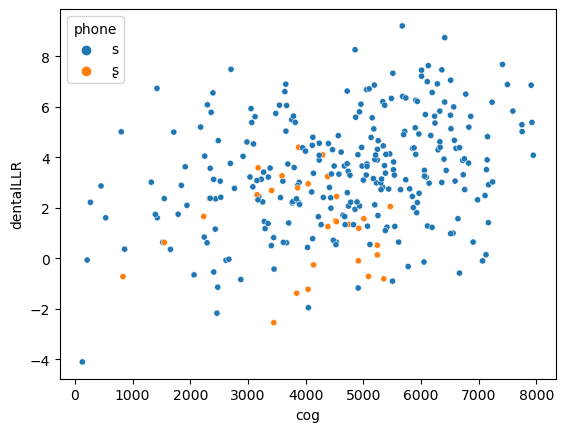

In [15]:
sns.scatterplot(x="cog", y="dentalLLR", 
                hue="phone",
                data=fa_merged_df.query("t<3"), s=20)

<Axes: xlabel='cog', ylabel='dentalLLR'>

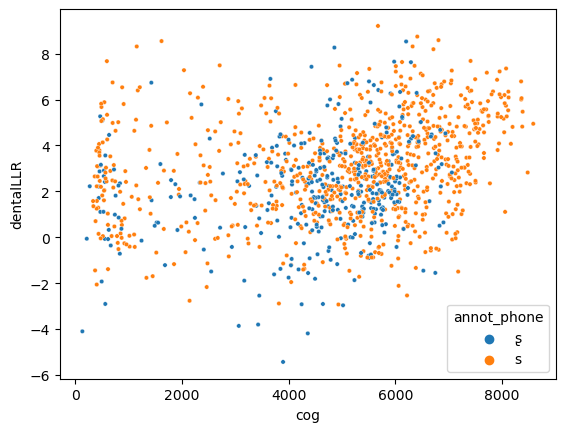

In [15]:
sns.scatterplot(x="cog", y="dentalLLR", 
                hue="annot_phone",
                data=fa_merged_df, s=10)

In [25]:
acfeats_nsteps = acfeats_df.groupby("file").count().loc[:,'times']
fafeats_nsteps = fafeats_df.groupby("utt_id").count().loc[:,'t']

In [26]:
370/25

14.8

In [27]:
fafeats_nsteps.align(acfeats_nsteps, join='inner')

(utt_id
 CJH_GY_1544    35
 CJH_GY_2944    30
 CJJ_GY_3607    62
 CJJ_GY_3612    28
 CJJ_GY_3628    19
                ..
 ZWH_GY_1203    55
 ZWH_GY_1472    56
 ZWH_GY_2433    32
 ZWH_GY_5140    64
 ZWH_GY_5146    33
 Name: t, Length: 101, dtype: int64,
 file
 CJH_GY_1544    25
 CJH_GY_2944    24
 CJJ_GY_3607    45
 CJJ_GY_3612    23
 CJJ_GY_3628    17
                ..
 ZWH_GY_1203    41
 ZWH_GY_1472    42
 ZWH_GY_2433    23
 ZWH_GY_5140    46
 ZWH_GY_5146    26
 Name: times, Length: 101, dtype: int64)